In [1]:
from testproblems import generate_random_prob
from representations import bipartite_repr
from inputresolver import resolve,invert_edges,getallvars,direct_eqs
from datastructures.polycasebuilder import eqv_to_edges_tree
from datastructures.graphutils import flat_graph_formulation, draw_graph_graphical_props
from datastructures.operators import sort_scc
#from networkx.algorithms.bipartite import random_graph as bipartite_random_graph

In [2]:
import numpy as np
import networkx as nx

In [3]:
from ipywidgets import IntProgress
from IPython.display import display
import time

In [4]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [5]:
rng = np.random.default_rng()

In [6]:
n_eqs = 7
n_vars = 10
seed = 8#8 is triang#seed 10 is nice 42
sparsity = 1.7#0.87#0.8 1.1 #1.7 1.3
eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed, sparsity)
eqs=direct_eqs(eqv, dout)
output_set = {key:var-n_eqs for key,var in dout.items()}

In [7]:
edges, tree = eqv_to_edges_tree(eqv, output_set, n_eqs)

In [8]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
maxscc = max([len(elt) for elt in merge_order])

In [9]:
#draw_graph_graphical_props(G, {}, prog='neato', figsize=(6,6))

In [10]:
maxscc

6

In [11]:
_, edges_original = bipartite_repr(eqv)
avrs = getallvars(eqs, sympy=False)
eqns = eqs.keys()
graph_edges = invert_edges(edges_original)

# Brute force feedback

In [12]:
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

In [13]:
def dir_graph(undir_edges, rightset, selected):
    # edge order independent in selected and undir_edges
    for node1, node2 in undir_edges:
        if ((node1,node2) in selected or (node2,node1) in selected):
            yield (node2,node1) if node2 in rightset else (node1, node2)
        else:
            yield (node1,node2) if node2 in rightset else (node2, node1)

In [14]:
def heuristic_permute_tear(undir_edges, rightset):
    # edge order independent
    G = nx.Graph(undir_edges)
    G_original = G.copy()
    assignment = tuple()
    vertexelim = set()
    while G.nodes():
        degree = dict(G.degree(rightset))
        mindegarg = min(degree, key=degree.get)
        argneighbors = list(G.neighbors(mindegarg))
        G.remove_node(mindegarg)
        if degree[mindegarg] != 0:
            assignment += ((mindegarg,argneighbors[0]),)
        else:
            vertexelim.add((mindegarg, tuple(G_original.neighbors(mindegarg))))
        for neighbor in argneighbors:
            G.remove_node(neighbor)
    return assignment, vertexelim

In [222]:
def generate_all_scc(dedges, velim):
    scc_full = set() # make sure we don't run into repeated cycles
    for v, neighbors in velim:
        D = nx.DiGraph(dedges)
        for u in neighbors:
            D.remove_edge(u,v)
            D.add_edge(v,u)
            S = nx.strongly_connected_components(D)
            scc_nonatomic = (elt for elt in S if len(elt)>1)
            for scc in scc_nonatomic:
                scc_full.add(tuple(scc))
    return scc_full

In [223]:
def assign_get_cycles_heuristic(xval, xref, rightset):
    edges_left_right = xref.keys()
    selected = tuple((right, left) for left, right in edges_left_right if xval[left, right] > 0.5)
    D = nx.DiGraph(dir_graph(edges_left_right, rightset, selected))
    S = nx.strongly_connected_components(D)
    cycles_original = {tuple(elt) for elt in S if len(elt)>1}
    keep_edges = [(left,right) for (left,right) in edges_left_right if (right,left) not in selected]
    #print(selected)
    #print(edges_left_right)
    #print(keep_edges)
    assignment, vertexelim = heuristic_permute_tear(keep_edges, rightset)
    #print(assignment, vertexelim)
    dedges = list(dir_graph(keep_edges, rightset, assignment))
    #print(dedges)
    cycles = generate_all_scc(dedges, vertexelim)
    dedges2 = list(dir_graph(edges_left_right, rightset, assignment+selected))
    cycles2 = generate_all_scc(dedges2, vertexelim)
    return cycles_original.union(cycles).union(cycles2)

In [15]:
def generate_all_scc2(dedges, velim):
    all_cycles = set() # make sure we don't run into repeated cycles
    for v, neighbors in velim:
        D = nx.DiGraph(dedges)
        for u in neighbors:
            D.remove_edge(u,v)
            D.add_edge(v,u)
            scycles = nx.simple_cycles(D)
            for cycle in scycles:
                all_cycles.add(tuple(cycle))
    return all_cycles

In [16]:
def assign_get_cycles_heuristic2(xval, xref, rightset):
    edges_left_right = xref.keys()
    selected = tuple((right, left) for left, right in edges_left_right if xval[left, right] > 0.5)
    D = nx.DiGraph(dir_graph(edges_left_right, rightset, selected))
    S = nx.simple_cycles(D)
    cycles_original = {tuple(elt) for elt in S}
    keep_edges = [(left,right) for (left,right) in edges_left_right if (right,left) not in selected]
    #print(selected)
    #print(edges_left_right)
    #print(keep_edges)
    assignment, vertexelim = heuristic_permute_tear(keep_edges, rightset)
    #print(assignment, vertexelim)
    dedges = list(dir_graph(keep_edges, rightset, assignment))
    #print(dedges)
    cycles = generate_all_scc2(dedges, vertexelim)
    dedges2 = list(dir_graph(edges_left_right, rightset, assignment+selected))
    cycles2 = generate_all_scc2(dedges2, vertexelim)
    return cycles_original.union(cycles).union(cycles2)

In [224]:
# def assign_get_cycles(xval, xref, edges):
#     selected = gp.tuplelist((i, j) for i, j in xref.keys()
#                                 if xval[i, j] > 0.5)
#     dir_edges = ([(r,j) if (r,j) in selected else (j,r) for (r,j) in edges])
#     D = nx.DiGraph(dir_edges)
#     S = nx.strongly_connected_components(D)
#     cycles = [elt for elt in S if len(elt)>1]
#     return cycles, D

In [225]:
# def assign_get_cycles(yval, yref, xval, xref, edges):
#     selected = gp.tuplelist((i, j) for i, j in xref.keys()
#                                 if xval[i, j] > 0.5)
#     dir_edges = dir_graph(edges, selected)
#     X = nx.DiGraph(dir_edges)
#     elim_set = {i for i in yref.keys() if yval[i] > 0.5}
#     D = X.subgraph(X.nodes()-elim_set)
#     S = nx.strongly_connected_components(D)
#     cycles = [elt for elt in S if len(elt)>1]
#     return cycles, D, elim_set

In [17]:
def assignsccelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        x_sol = model.cbGetSolution(model._x)
        cycles = assign_get_cycles_heuristic(x_sol, model._x, model._rightset)
        for idx, cycle in enumerate(cycles):
            g = model._G.subgraph(cycle)
            model.cbLazy(gp.quicksum(model._x[edge] if edge in model._x else model._x[edge[::-1]] for edge in g.edges())<=len(cycle)/2-1)

In [18]:
def assigncycleelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        x_sol = model.cbGetSolution(model._x)
        cycles = assign_get_cycles_heuristic2(x_sol, model._x, model._rightset)
        for idx, cycle in enumerate(cycles):
            g = model._G.subgraph(cycle)
            model.cbLazy(gp.quicksum(model._x[edge] if edge in model._x else model._x[edge[::-1]] for edge in g.edges())<=len(cycle)/2-1)

In [19]:
def min_arc_set_assign(edges_left_right, leftset, rightset):
    G = nx.Graph(edges_left_right)
    m = gp.Model('cycles')
    m.setParam('OutputFlag', False )
    m.setParam('TimeLimit', 3600)
    x = m.addVars(edges_left_right, name="assign", vtype=GRB.BINARY)
    # A variable node can have maximum one ouput edge (possibly of none)
    m.addConstrs((x.sum('*',i) <= 1 for i in rightset), name='equations')
    # An equation node shall have one output edge unless part of elimination set
    m.addConstrs((x.sum(i,'*') <= 1 for i in leftset), name='variables')
    m.setObjective(x.sum('*'), GRB.MAXIMIZE)
    m._rightset = rightset
    m._G = G
    m._x = x
    m.Params.lazyConstraints = 1
    m.optimize(assigncycleelim)
    return m.getAttr('x', x), m

In [26]:
edges_original

[(7, 0),
 (14, 0),
 (15, 0),
 (10, 0),
 (8, 1),
 (9, 1),
 (10, 1),
 (16, 1),
 (14, 2),
 (15, 2),
 (7, 3),
 (9, 3),
 (11, 3),
 (13, 3),
 (14, 3),
 (12, 3),
 (8, 4),
 (9, 4),
 (10, 4),
 (11, 4),
 (12, 4),
 (13, 4),
 (8, 5),
 (9, 5),
 (10, 5),
 (11, 5),
 (14, 5),
 (10, 6),
 (11, 6),
 (13, 6),
 (14, 6),
 (7, 6)]

In [28]:
avrs, eqns

({7, 8, 9, 10, 11, 12, 13, 14, 15, 16}, dict_keys([0, 1, 2, 3, 4, 5, 6]))

In [20]:
xsol,m =  min_arc_set_assign(edges_original, avrs, eqns)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [21]:
sum(xsol.values())

6.0

In [22]:
selected = tuple((right, left) for left, right in edges_original if xsol[left, right] > 0.5)
D = nx.DiGraph(dir_graph(edges_original, eqns, selected))

In [23]:
S = nx.strongly_connected_components(D)

In [24]:
list(S)

[{16},
 {1},
 {4},
 {8},
 {5},
 {9},
 {3},
 {11},
 {6},
 {10},
 {0},
 {7},
 {15},
 {2},
 {14},
 {13},
 {12}]

In [118]:
selected

((0, 36),
 (1, 28),
 (2, 22),
 (3, 34),
 (4, 37),
 (5, 30),
 (6, 40),
 (7, 43),
 (8, 23),
 (9, 25),
 (10, 32),
 (11, 20),
 (12, 41),
 (13, 26),
 (14, 39),
 (15, 24),
 (16, 33),
 (17, 21),
 (18, 35),
 (19, 44))

In [401]:
elimset

{0, 9, 11, 15, 17}

In [431]:
nx.is_directed_acyclic_graph(D)

True

In [334]:
elimset

{8}

In [403]:
elimedges = ((elt, dout[elt]) for elt in elimset)
ec = nx.DiGraph(D.edges())
ec.remove_edges_from(elimedges)
nx.is_directed_acyclic_graph(ec)

True

In [259]:
D.edges()

OutEdgeView([(3, 0), (0, 5), (6, 0), (6, 1), (7, 0), (7, 1), (1, 3), (4, 1)])

# Min arc feedback problem

In [22]:
def get_cycles(yval, yref, X):
    # elimination set = nodes with 1s
    elimset = {i for i in yref.keys() if yval[i] > 0.5}
    D = X.subgraph(X.nodes()-elimset)
    S = nx.strongly_connected_components(D)
    cycles = [elt for elt in S if len(elt)>1]
    return cycles, elimset

In [23]:
def sccelim(model, where):
    if where == GRB.Callback.MIPSOL:
        y_sol = model.cbGetSolution(model._y)
        cycles,_ = get_cycles(y_sol, model._y, model._X)
        for idx, cycle in enumerate(cycles):
            cycle_eqnodes = cycle.intersection(model._y.keys())
            model.cbLazy(gp.quicksum(model._y[node] for node in cycle_eqnodes)>=1)

In [43]:
def min_arc_set(edges, dout, vrs, eqns):
    G = nx.Graph(edges)
    X = nx.DiGraph(dir_graph(edges, vrs, dout.items()))
    # make sure edges are in the right order
    m = gp.Model('cycles')
    m.setParam('OutputFlag', False )
    m.setParam('TimeLimit', 100)
    y = m.addVars(eqns, name="elimination", vtype=GRB.BINARY)
    m.setObjective(y.sum('*'), GRB.MINIMIZE)
    m._edges = edges
    m._G = G
    m._X = X
    m._y = y
    m.Params.lazyConstraints = 1
    m.optimize(sccelim)
    cycles, elimset = get_cycles(m.getAttr('x', y), y, X)
    return cycles, elimset

In [25]:
outset=dout #selected

In [44]:
_, elimset = min_arc_set(graph_edges, outset, avrs, eqns)

In [45]:
elimset

{4, 11, 15, 16, 17, 18}

In [33]:
elimedges = [(elt, outset[elt]) for elt in elimset]
elimedges

[(4, 34), (11, 23), (15, 41), (16, 25), (17, 30), (18, 35)]

In [35]:
ec = nx.DiGraph(dir_graph(graph_edges, eqns, outset.items()))
ec.edges()
ec.remove_edges_from(elimedges)

In [36]:
nx.is_directed_acyclic_graph(ec)

True

In [37]:
def generate_acyclic(graph_edges, elimset, outset, vrs):
    elimedges = ((outset[elt], elt) for elt in elimset)
    ec = nx.DiGraph(dir_graph(graph_edges, vrs, outset.items()))
    ec.edges()
    ec.remove_edges_from(elimedges)
    return ec

In [38]:
ec = generate_acyclic(graph_edges, elimset, outset, avrs)

In [39]:
nx.is_directed_acyclic_graph(ec)

True

In [381]:
elimset

{3, 4, 7, 12}

In [301]:
elimedges = ((elt, dout[elt]) for elt in elimset)

In [305]:
ec = nx.DiGraph(dir_graph(graph_edges, dout.items()))

In [306]:
ec.edges()

OutEdgeView([(10, 0), (10, 1), (10, 4), (10, 5), (10, 6), (10, 8), (0, 21), (20, 0), (20, 2), (20, 6), (21, 4), (1, 17), (11, 1), (11, 3), (11, 4), (11, 6), (11, 7), (12, 1), (12, 4), (12, 9), (17, 3), (19, 2), (2, 13), (24, 2), (24, 4), (24, 8), (13, 3), (13, 8), (13, 9), (3, 24), (16, 3), (16, 6), (23, 3), (23, 4), (4, 19), (14, 4), (14, 6), (14, 7), (14, 8), (5, 11), (6, 15), (22, 6), (22, 9), (15, 8), (7, 18), (8, 20), (9, 10)])

In [307]:
ec.remove_edges_from(elimedges)

In [308]:
nx.is_directed_acyclic_graph(ec)

True

In [90]:
dir_graph(graph_edges, dout.items())

[(3, 0), (4, 0), (5, 0), (6, 0), (0, 7), (3, 1), (1, 6), (2, 3), (6, 2)]

In [91]:
G = nx.DiGraph(dir_graph(graph_edges, dout.items()))
H = G.subgraph([0, 1, 2])

In [73]:
dout

{1: 6, 2: 3, 0: 7}

In [81]:
H.edges()

OutEdgeView([])

In [82]:
G = nx.Graph()
G.add_edges_from([(3, 0), (4, 0), (5, 0), (6, 0), (0, 7), (3, 1), (1, 6), (2, 3), (6, 2)])  # or DiGraph, MultiGraph, MultiDiGraph, etc
H = G.subgraph([0, 1, 2])

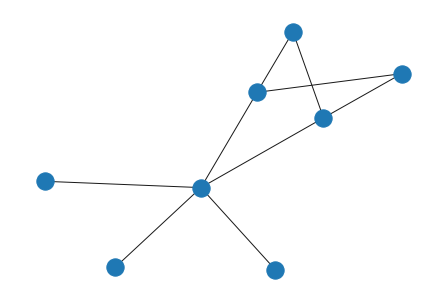

In [85]:
nx.draw(G)

In [84]:
list(H.edges)

[]

# Preprocessor

In [63]:
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

In [346]:
def scc(sol, edges):
    D = nx.DiGraph([(r,j) if (r,j) in sol else (j,r) for (r,j) in edges])
    return list(nx.strongly_connected_components(D))

In [347]:
def recoversol(xval, xref, edges):
    selected = gp.tuplelist((i, j) for i, j in xref.keys()
                                if xval[i, j] > 0.5)
    dir_edges = ([(r,j) if (r,j) in selected else (j,r) for (r,j) in edges])
    D = nx.DiGraph(dir_edges)
    S = nx.strongly_connected_components(D)
    cycles = [elt for elt in S if len(elt)>1]
    return cycles, D

In [348]:
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        x_sol = model.cbGetSolution(model._x)
        cycles, _ = recoversol(x_sol, model._x, model._edges)
        for idx, cycle in enumerate(cycles):
            g = model._G.subgraph(cycle)
            model.cbLazy(gp.quicksum(model._x[edge] if edge in model._x else model._x[edge[::-1]] for edge in g.edges())<=model._c)

In [349]:
def var_matched_cons(x, j, not_input=None):
    if not_input == None:
        not_input = []
    if j in not_input:
        return x.sum('*',j) == 1
    else:
        return x.sum('*',j) <= 1

In [353]:
def min_max_scc(edges, vrs, eqns, n_eqs):
    G = nx.Graph(edges)
    # make sure edges are in the right order
    m = gp.Model('cycles')
    m.setParam('OutputFlag', False )
    m.setParam('TimeLimit', 10)
    x = m.addVars(edges, name="assign", vtype=GRB.BINARY)
    c = m.addVar(lb=0.0)
    # Matching eqs:
    m.addConstrs((x.sum(j,'*') == 1 for j in eqns), name='equations')
    m.addConstrs((var_matched_cons(x, j) for j in vrs), name='variables')
    m.setObjective(c, GRB.MINIMIZE)
    m._edges = edges
    m._G = G
    m._x = x
    m._c = c
    m.Params.lazyConstraints = 1
    m.optimize(subtourelim)
    cycles, D = recoversol(m.getAttr('x', x), x, edges)
    return max([len(cycle)/2 for cycle in cycles]+[0]), m

In [386]:
maxl, m = min_max_scc(graph_edges, avrs, eqns, len(eqns))

In [387]:
selected = dict((i, j) for i, j in m._x.keys()
                                if m.getAttr('x', m._x)[i, j] > 0.5)

In [388]:
selected

{0: 42,
 1: 26,
 2: 22,
 3: 23,
 4: 31,
 5: 36,
 6: 41,
 7: 35,
 8: 30,
 9: 40,
 10: 27,
 11: 34,
 12: 33,
 13: 43,
 14: 39,
 15: 37,
 16: 38,
 17: 29,
 18: 24,
 19: 44}

In [19]:
edges = graph_edges
vrs = avrs
G = nx.Graph(edges)
n_eqs = len(eqns)
# make sure edges are in the right order
m = gp.Model('cycles')
m.setParam('OutputFlag', False )
m.setParam('TimeLimit', 100)
x = m.addVars(edges, name="assign", vtype=GRB.BINARY)
c = m.addVar(lb=0.0)
# Matching eqs:
m.addConstrs((x.sum(j,'*') == 1 for j in eqns), name='equations')
m.addConstrs((var_matched_cons(x, j) for j in vrs), name='variables')
m.setObjective(c, GRB.MINIMIZE)
m._edges = edges
m._G = G
m._x = x
m._c = c
m.Params.lazyConstraints = 1

In [20]:
m.optimize(subtourelim)

In [36]:
cycles, D = recoversol(m.getAttr('x', x), x)

In [37]:
[len(cycle)/2 for cycle in cycles]

[60.0, 2.0, 2.0]

In [94]:
x_sol = m.getAttr('x', x)

In [97]:
selected = gp.tuplelist((i, j) for i, j in x_sol.keys()
                                if x_sol[i, j] > 0.5)
dir_edges = ([(r,j) if (r,j) in selected else (j,r) for (r,j) in edges])
D = nx.DiGraph(dir_edges)
S = nx.strongly_connected_components(D)

In [99]:
list(S)

[{1, 2, 3, 5}, {4}, {0}, {6}, {7}]

In [91]:
m.getAttr('x', x)

{(0, 4): 1.0,
 (0, 6): 0.0,
 (0, 7): 0.0,
 (1, 3): -0.0,
 (1, 4): -0.0,
 (1, 5): 1.0,
 (1, 6): -0.0,
 (1, 7): -0.0,
 (2, 3): 1.0,
 (2, 4): 0.0,
 (2, 5): -0.0,
 (2, 6): 0.0,
 (2, 7): 0.0}

In [25]:
_, edges_original = bipartite_repr(eqv)
avrs = getallvars(eqs, sympy=False)
eqns = eqs.keys()
graph_edges = invert_edges(edges_original)
output = resolve(eqns, avrs, graph_edges, 50)
soutput = sorted(output, key=lambda x: x['CLEN'])
bestsccseq = soutput[0]['CLEN']

No feasible solution


In [28]:
len(soutput)

36

In [8]:
A = np.zeros((n_eqs, n_vars)).astype(int)
permutation = range(n_eqs, n_vars+n_eqs)
for idx, (out,varsineq) in eqs.items():
    for var in varsineq+(out,):
        col = permutation.index(var)
        A[idx,col] = 1

In [10]:
print('A=[{}]'.format(';\n '.join([' '.join([str(elt) for elt in row]) for row in A])))

A=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0;
 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1;
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1;
 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0;
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0;
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0;
 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1;
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0;
 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0;
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0;
 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0;
 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0;
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0;
 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0;
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0;
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1;
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0;
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1;
 0 0 0 0 0

In [7]:
N = 20
n_eqs = 100
n_vars = 130
sparsity = 1.7

In [8]:
dfcontent = dict()

In [76]:
import pandas as pd

In [126]:
sparsities = np.round(np.logspace(np.log10(0.5), np.log10(1.5),3),2)
dofs = [10]
N = 100
seeds = rng.choice(10*N, size=N, replace=False)
n_eqs = 50

In [127]:
max_count = len(sparsities)*len(dofs)*N

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar
count = 0
stats = []
for sparsity in sparsities:
    for dof in dofs:
        n_vars = n_eqs+dof
        for elt in range(N):
            f.value += 1
            seed = int(seeds[elt])
            eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed, sparsity)
            edges, tree = eqv_to_edges_tree(eqv, output_set, n_eqs)
            output_set = {key:var-n_eqs for key,var in dout.items()}
            G = flat_graph_formulation(*edges)
            merge_order = sort_scc(G)
            maxscc = max([len(elt) for elt in merge_order])
            stats.append({"largestSCC":maxscc, "DOFs":dof, "sparsity":sparsity, "type":"default"})
            eqs=direct_eqs(eqv, dout)
            _, edges_original = bipartite_repr(eqv)
            avrs = getallvars(eqs, sympy=False)
            eqns = eqs.keys()
            graph_edges = invert_edges(edges_original)
            #output = resolve(eqns, avrs, graph_edges, 50)
            #soutput = sorted(output, key=lambda x: x['CLEN'])
            #bestsccseq = soutput[0]['CLEN']
            #better_maxscc = max(bestsccseq) if bestsccseq else 0
            better_maxscc = min_max_scc(graph_edges, avrs, len(eqns))
            stats.append({"largestSCC":better_maxscc, "DOFs":dof, "sparsity":sparsity, "type":"optimized"})

IntProgress(value=0, max=300)

In [128]:
df = pd.DataFrame(stats)

In [129]:
df

,largestSCC,DOFs,sparsity,type
0,2.0,10,0.5,default
1,2.0,10,0.5,optimized
2,7.0,10,0.5,default
3,7.0,10,0.5,optimized
4,1.0,10,0.5,default
...,...,...,...,...
595,33.0,10,1.5,optimized
596,48.0,10,1.5,default
597,36.0,10,1.5,optimized
598,46.0,10,1.5,default


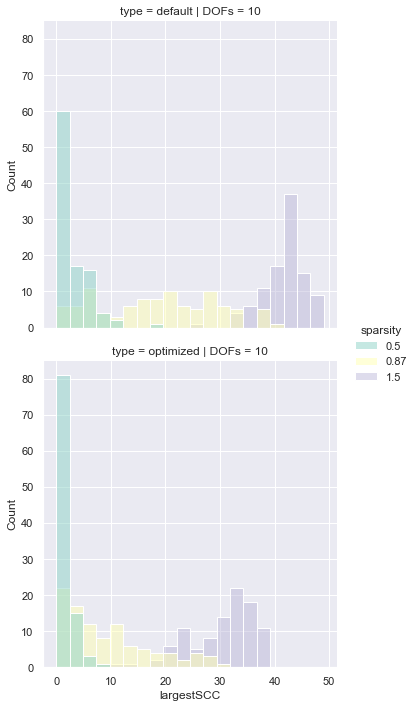

In [130]:
sns.displot(df, x="largestSCC", col="DOFs", row="type", hue="sparsity", palette="Set3", bins=20);

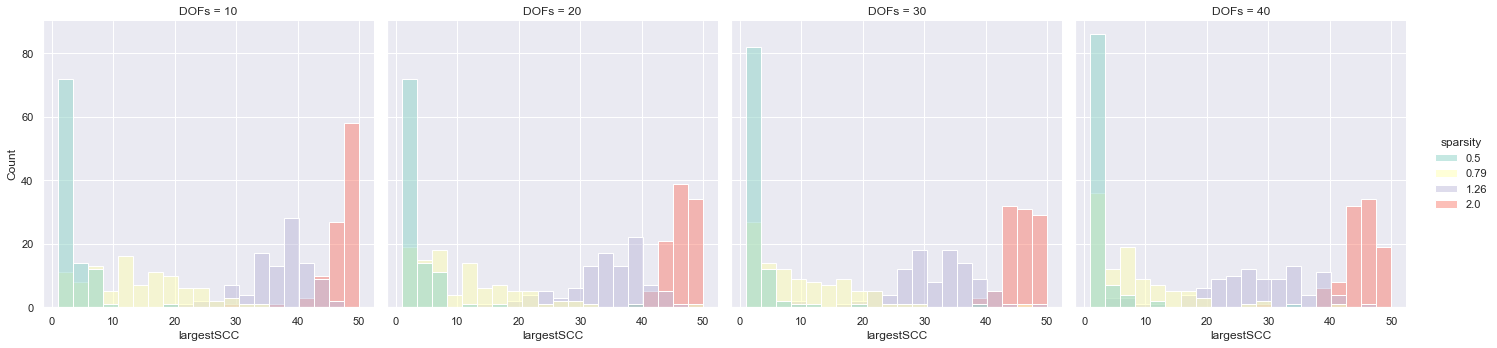

In [97]:
sns.displot(df, x="largestSCC", col="DOFs", hue="sparsity", palette="Set3", bins=20);

In [18]:
edges, tree = eqv_to_edges_tree(eqv, output_set, n_eqs)

In [19]:
G = flat_graph_formulation(*edges)

In [20]:
merge_order = sort_scc(G)

In [21]:
[len(elt) for elt in merge_order]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 84, 1, 1, 1, 1, 1, 1, 1]

In [8]:
eqs=direct_eqs(eqv, dout)
_, edges_original = bipartite_repr(eqv)
avrs = getallvars(eqs, sympy=False)
eqns = eqs.keys()
graph_edges = invert_edges(edges_original)

In [9]:
output = resolve(eqns, avrs, graph_edges, 200)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [10]:
soutput = sorted(output, key=lambda x: x['CLEN'])

In [11]:
soutput[0]['CLEN']

[79.0, 2.0]